In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [7]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/HRD/datasets/brca.HRD_Score.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]
# df

In [8]:
# Normalize HIFs and define X, y
X = df.iloc[:,1:608]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..STROMA._HE,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE
0,0.751156,1.405408,-0.237077,2.252051,1.591300,-0.594106,0.018361,0.594106,0.374798,0.283978,...,1.212387,1.143992,0.615602,1.768560,1.829732,1.731723,1.856485,1.359563,1.040098,1.293408
1,1.025322,2.194958,-0.124386,2.926241,2.096029,-0.649181,0.453261,0.649181,0.216974,0.259009,...,0.104808,0.021906,0.119639,0.718996,0.868987,0.789646,-0.283304,-0.177085,-0.089874,-0.141225
2,-0.411995,-0.127494,-0.058021,-0.005644,-0.239809,-0.544756,0.494043,0.544756,-0.725523,0.105526,...,-0.135872,-0.218640,-0.357482,-0.010027,0.035480,-0.036559,-0.395138,-0.269047,-0.196680,-0.255149
3,0.008724,1.046086,-0.267981,1.548318,0.802103,-1.009646,0.752933,1.009646,0.917123,1.026561,...,-0.217730,-0.226687,-0.245387,-0.238465,-0.156957,-0.185114,-0.188273,-0.274562,-0.317921,-0.304434
4,-1.090079,-1.143786,-0.203914,-1.052809,-1.168807,-2.481822,-2.190111,2.481822,-2.401226,-3.140076,...,-0.479680,-0.541010,-0.706859,-0.653711,-0.533725,-0.605250,-0.497451,-0.420678,-0.396846,-0.442933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,-0.851433,-0.965521,-0.316672,-0.955414,-0.981442,0.005660,-0.758178,-0.005660,-1.473889,0.015073,...,-0.619845,-0.658535,-0.307981,-0.690553,-0.700949,-0.677102,-0.480834,-0.418486,-0.399096,-0.440784
692,-0.336752,-0.239586,-0.322476,-0.622148,-0.513924,0.661095,1.413241,-0.661095,-0.342021,1.173717,...,-0.581999,-0.586705,-0.512370,-0.607399,-0.719979,-0.732703,0.033156,-0.230308,-0.385429,-0.306404
693,0.170327,0.559028,-0.321787,0.510310,0.360653,-0.123371,0.709886,0.123371,-0.681115,-0.125499,...,-0.329411,-0.202952,1.985009,-0.131895,-0.442350,-0.013518,0.096821,-0.201603,-0.329502,-0.245525
694,-0.798522,-0.786082,-0.217507,-0.927058,-0.936419,0.176267,1.019478,-0.176267,-1.009162,-0.937834,...,-0.554138,-0.532279,-0.295846,-0.541418,-0.723140,-0.694382,-0.262580,-0.335029,-0.405353,-0.393559


In [9]:
y = df.iloc[:,609]
# print(np.sum(y))

In [11]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/BRCA.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
# clusters

Number of Clusters: 20


## Define Nested CV Parameters

In [12]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

232 232
232 232
232 232
0.16810344827586207
0.16379310344827586
0.16810344827586207


### Outer Loop 1

In [13]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(464, 607) (464,)
(232, 607) (232,)


In [14]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.6725863025863025, 0.6808577533577533, 0.6829209679209679, 0.6917610167610168, 0.6980516705516706, 0.7035200910200909, 0.6794028194028193, 0.6817121767121768, 0.7083596958596958, 0.6996375846375847, 0.6711507936507937, 0.6252097902097902, 0.707400654900655, 0.6484282384282385, 0.6422713397713398, 0.735396547896548, 0.7371006771006772, 0.6842352092352093, 0.7187193362193363, 0.7105283605283607, 0.7219258519258519, 0.7166924741924742, 0.6804856254856254, 0.5877125652125652, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


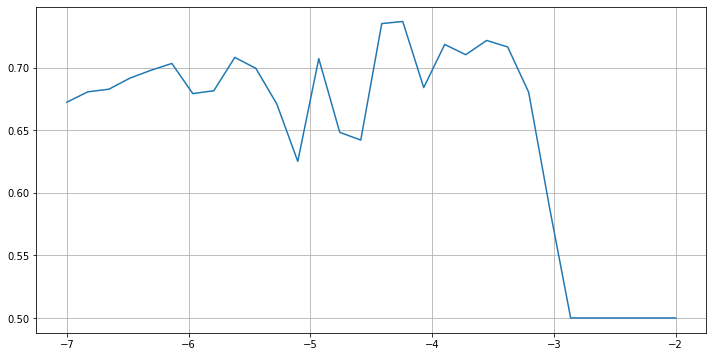

0.014387733001540358 -4.241379310344827


In [16]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -4.0
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

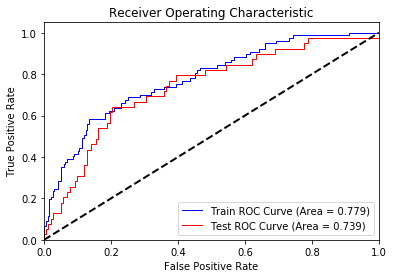

In [42]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

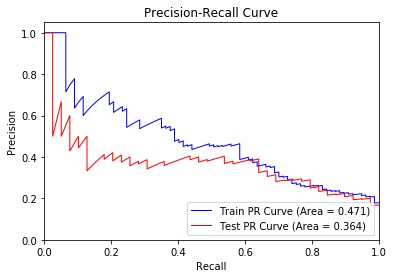

In [43]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [44]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 79


,HIF,Beta,Cluster
465,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF NECROSIS_HE,0.365191,2
516,REGION PROPERTIES: PERIMETER^2 / AREA OF SIGNIFICANT REGIONS OF NECROSIS_HE,0.233539,20
208,COUNT PROP [FIBROBLAST CELLS] IN [[STROMA] OVER [TUMOR]]_HE,0.185804,14
568,REGION PROPERTIES: TOTAL PERIMETER (MM) OF NECROSIS_HE,0.160719,2
558,REGION PROPERTIES: TOTAL MAJOR AXIS LENGTH (MM) OF NECROSIS_HE,0.138609,2
...,...,...,...
83,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT STANDARD DEVIATION OF MACROPHAGE IN TUMOR_HE,-0.118455,11
211,COUNT PROP [FIBROBLAST CELLS] IN [[TUMOR] OVER [STROMA]]_HE,-0.122661,14
201,COUNT PROP [FIBROBLAST CELLS] IN [[EPITHELIAL] OVER [STROMA]]_HE,-0.122661,14
235,COUNT PROP [MACROPHAGE CELLS] IN [[TUMOR] OVER [STROMA]]_HE,-0.139458,14


### Outer Loop 2

In [45]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(464, 607) (464,)
(232, 607) (232,)


In [46]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.6465409590409591, 0.6409543234543233, 0.6282570207570208, 0.6284126984126984, 0.6183466533466533, 0.6359310134310134, 0.6606127206127206, 0.6570260295260295, 0.644538517038517, 0.6591297591297591, 0.6728518703518704, 0.6859523809523809, 0.6667979242979243, 0.6911235986235986, 0.7040029415029416, 0.7150704850704851, 0.7215434565434565, 0.7293389943389943, 0.7337989787989787, 0.7368894993894994, 0.7382942057942057, 0.7375888000888, 0.7382689532689534, 0.7335683760683761, 0.7231793206793207, 0.7120781995781995, 0.7013150738150737, 0.6682869907869907, 0.6263389388389389, 0.5420512820512821]


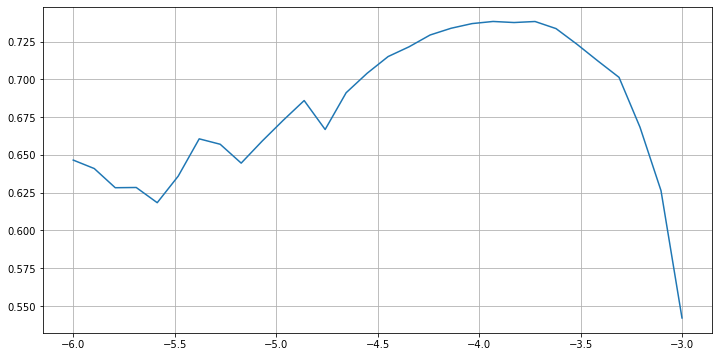

0.019623362019752715 -3.93103448275862


In [48]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -4.3
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

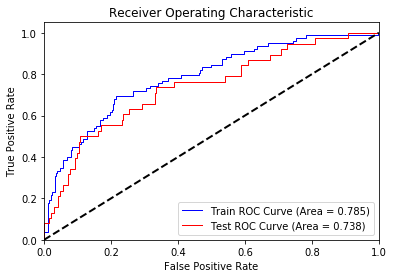

In [65]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# plt.show()

# Save figure
plt.savefig('./roc_curves/HRD.roc.2.logreg=%0.2f.png' % optimal_log_reg, dpi=150)

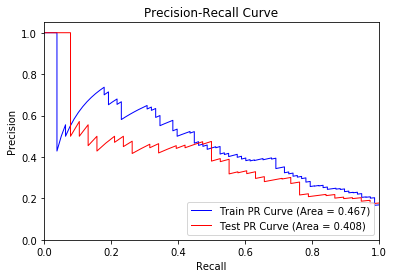

In [66]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [67]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 55


,HIF,Beta,Cluster
568,REGION PROPERTIES: TOTAL PERIMETER (MM) OF NECROSIS_HE,0.104915,2
465,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF NECROSIS_HE,0.069351,2
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,0.061139,2
553,REGION PROPERTIES: TOTAL FILLED AREA (MM2) OF NECROSIS_HE,0.060534,2
468,REGION PROPERTIES: FRACTAL DIMENSION OF NECROSIS_HE,0.059351,2
125,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF PLASMA IN ESI_0080_HE,0.044385,8
483,REGION PROPERTIES: MAJOR AXIS LENGTH (MM) OF LARGEST REGION OF NECROSIS_HE,0.042211,2
558,REGION PROPERTIES: TOTAL MAJOR AXIS LENGTH (MM) OF NECROSIS_HE,0.037967,2
185,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF PLASMA IN ESI_0080_HE,0.034990,8
326,COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY [LY...,0.031384,8


### Outer Loop 3

In [68]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(464, 607) (464,)
(232, 607) (232,)


In [69]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.600541403041403, 0.6284521034521033, 0.6045387945387946, 0.6321783771783772, 0.6351770451770451, 0.6289227439227439, 0.6375865800865801, 0.633955488955489, 0.644014874014874, 0.6814713064713065, 0.6489357864357863, 0.6675063825063825, 0.6731343656343656, 0.6485977910977911, 0.6607384282384283, 0.6678213453213454, 0.6730866355866356, 0.6957681207681208, 0.6686771561771562, 0.6896467421467423, 0.652755022755023, 0.6917246642246642, 0.6824503274503274, 0.6977317127317127, 0.6257742257742256, 0.6868403818403819, 0.6721986346986346, 0.6641161616161616, 0.6539502164502164, 0.5924847374847375]


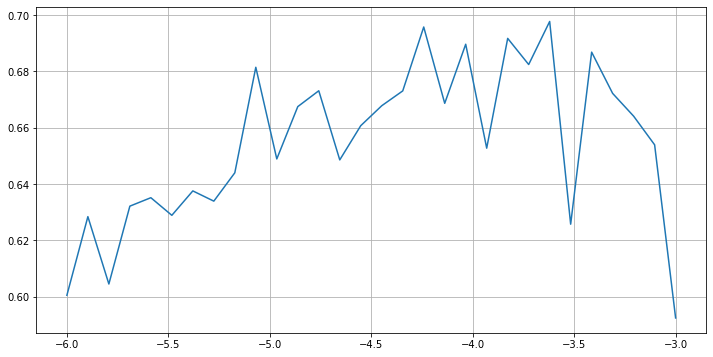

0.026764212049045312 -3.6206896551724137


In [71]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -4.3
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

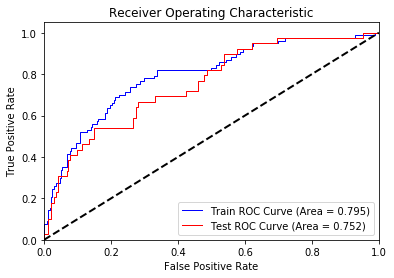

In [81]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

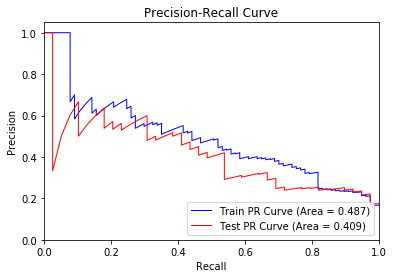

In [82]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [83]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 275


,HIF,Beta,Cluster
468,REGION PROPERTIES: FRACTAL DIMENSION OF NECROSIS_HE,0.283917,2
465,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF NECROSIS_HE,0.200761,2
232,COUNT PROP [MACROPHAGE CELLS] IN [[STROMA] OVER [TUMOR]]_HE,0.169419,14
84,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT STANDARD DEVIATION OF PLASMA IN EPITHELIAL_HE,0.152382,11
87,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT STANDARD DEVIATION OF PLASMA IN TUMOR_HE,0.135444,11
...,...,...,...
235,COUNT PROP [MACROPHAGE CELLS] IN [[TUMOR] OVER [STROMA]]_HE,-0.080868,14
368,DENSITY RATIO [MACROPHAGE CELLS] IN [[EPITHELIAL] OVER [ESI_0080]]_HE,-0.093896,3
370,DENSITY RATIO [MACROPHAGE CELLS] IN [[EPITHELIAL] OVER [TUMOR]]_HE,-0.101274,3
226,COUNT PROP [MACROPHAGE CELLS] IN [[EPITHELIAL] OVER [TUMOR]]_HE,-0.169419,14


## Compute Ensemble Model

In [84]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df[['HIF', 'Beta', 'Cluster']].to_csv("./model_coefficients/HRD_model_ensemble.csv")
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
465,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF NECROSIS_HE,0.365191,0.069351,0.200761,2,0.211768
468,REGION PROPERTIES: FRACTAL DIMENSION OF NECROSIS_HE,0.000000,0.059351,0.283917,2,0.114423
568,REGION PROPERTIES: TOTAL PERIMETER (MM) OF NECROSIS_HE,0.160719,0.104915,0.008925,2,0.091519
516,REGION PROPERTIES: PERIMETER^2 / AREA OF SIGNIFICANT REGIONS OF NECROSIS_HE,0.233539,0.000000,0.000000,20,0.077846
208,COUNT PROP [FIBROBLAST CELLS] IN [[STROMA] OVER [TUMOR]]_HE,0.185804,0.000000,0.046770,14,0.077525
...,...,...,...,...,...,...
172,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN EPITHE...,-0.107582,-0.028356,-0.041433,6,-0.059124
226,COUNT PROP [MACROPHAGE CELLS] IN [[EPITHELIAL] OVER [TUMOR]]_HE,0.000000,-0.030386,-0.169419,14,-0.066602
451,REGION PROPERTIES: EXTENT OF LARGEST REGION OF EPITHELIAL_HE,-0.000856,0.000000,-0.217172,13,-0.072676
235,COUNT PROP [MACROPHAGE CELLS] IN [[TUMOR] OVER [STROMA]]_HE,-0.139458,-0.005163,-0.080868,14,-0.075163


## Compute Final Train / Test Metrics

In [85]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.7787174066243834, 0.785173375846951, 0.7948253297090506]
0.7862387040601284 0.00661903767812878


In [86]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.7389398166600238, 0.7381985892566467, 0.7519596120632389]
0.7430326726599699 0.006319548499067952


In [87]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.47061145893411316, 0.46713412876016386, 0.4865433962170727]
0.4747629946371166 0.00845010265513342


In [88]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.3635856440700831, 0.4077074589740137, 0.40887423323410754]
0.3933891120927348 0.02107961685572773


## Evaluate Hold-Out Set

In [15]:
holdout_df = pd.read_csv("{0}/data/genetic_data/HRD/datasets/brca.HRD_Score.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
# holdout_df

In [16]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,1:608]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
# X_normalized_holdout

In [17]:
y_holdout = holdout_df.iloc[:,609]
print(np.sum(y_holdout))

26


In [ ]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [95]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

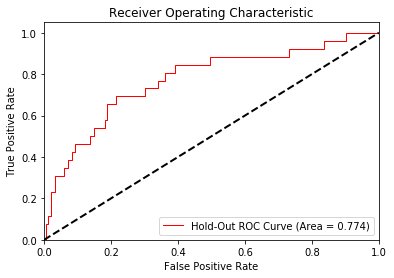

In [96]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.774


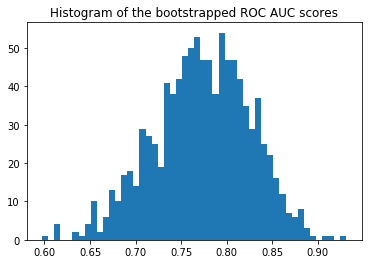

Confidence interval for the score: [0.665 - 0.867]


In [97]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

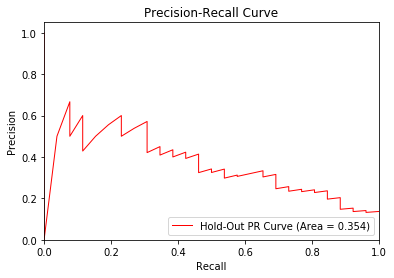

In [98]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.354


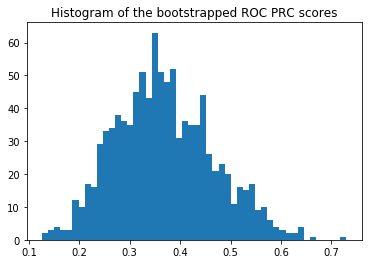

Confidence interval for the score: [0.196 - 0.57]


In [99]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))